In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import numpy as np
from distutils.version import LooseVersion
from dipy.utils.optpkg import optional_package
from tqdm import tqdm_notebook as tqdm
from scipy.ndimage import rotate

tf, have_tf, _ = optional_package('tensorflow')
layers, _, _ = optional_package("tensorflow.keras.layers")
matplotlib, has_mpl, setup_module = optional_package("matplotlib")
plt, _, _ = optional_package("matplotlib.pyplot")

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (12, 10)

if have_tf:
    if LooseVersion(tf.__version__) < LooseVersion('2.0.0'):
        raise ImportError('Please upgrade to TensorFlow 2+')
        
print(tf.__version__)
print(tf.keras.backend.image_data_format())

2.2.0
channels_last


<Figure size 432x288 with 0 Axes>

In [3]:
@tf.function
def mse_loss(static, moving):
    loss = tf.reduce_mean(tf.square(moving - static))  # shape ()
    return loss


@tf.function
def ncc_loss(static, moving):
    eps = tf.constant(1e-9, 'float32')

    static_mean = tf.reduce_mean(static, axis=[1, 2], keepdims=True)
    moving_mean = tf.reduce_mean(moving, axis=[1, 2], keepdims=True)
    # shape (N, 1, 1, C)

    static_std = tf.math.reduce_std(static, axis=[1, 2], keepdims=True)
    moving_std = tf.math.reduce_std(moving, axis=[1, 2], keepdims=True)
    # shape (N, 1, 1, C)

    static_hat = (static - static_mean)/(static_std + eps)
    moving_hat = (moving - moving_mean)/(moving_std + eps)
    # shape (N, H, W, C)
    ncc = tf.reduce_mean(static_hat * moving_hat)  # shape ()
    loss = -ncc
    return loss

In [4]:
# @tf.function
def regular_grid_2d(height, width):
    x = tf.linspace(-1.0, 1.0, width)  # shape (W, )
    y = tf.linspace(-1.0, 1.0, height)  # shape (H, )

    X, Y = tf.meshgrid(x, y)  # shape (H, W), both X and Y

    grid = tf.stack([X, Y], axis=-1)
    return grid


# @tf.function
def grid_sample_2d(moving, grid):
    nb, nh, nw, nc = tf.shape(moving)

    x = grid[..., 0]  # shape (N, H, W)
    y = grid[..., 1]
    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')

    # Scale x and y from [-1.0, 1.0] to [0, W] and [0, H] respectively.
    x = (x + 1.0) * 0.5 * tf.cast(nw-1, 'float32')
    y = (y + 1.0) * 0.5 * tf.cast(nh-1, 'float32')

    y_max = tf.cast(nh - 1, 'int32')
    x_max = tf.cast(nw - 1, 'int32')
    zero = tf.constant(0, 'int32')

    # The value at (x, y) is a weighted average of the values at the
    # four nearest integer locations: (x0, y0), (x1, y0), (x0, y1) and
    # (x1, y1) where x0 = floor(x), x1 = ceil(x).
    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    # Make sure indices are within the boundaries of the image.
    x0 = tf.clip_by_value(x0, zero, x_max)
    x1 = tf.clip_by_value(x1, zero, x_max)
    y0 = tf.clip_by_value(y0, zero, y_max)
    y1 = tf.clip_by_value(y1, zero, y_max)

    # Collect indices of the four corners.
    b = tf.ones_like(x0) * tf.reshape(tf.range(nb), [nb, 1, 1])
    idx_a = tf.stack([b, y0, x0], axis=-1)  # all top-left corners
    idx_b = tf.stack([b, y1, x0], axis=-1)  # all bottom-left corners
    idx_c = tf.stack([b, y0, x1], axis=-1)  # all top-right corners
    idx_d = tf.stack([b, y1, x1], axis=-1)  # all bottom-right corners
    # shape (N, H, W, 3)

    # Collect values at the corners.
    moving_a = tf.gather_nd(moving, idx_a)  # all top-left values
    moving_b = tf.gather_nd(moving, idx_b)  # all bottom-left values
    moving_c = tf.gather_nd(moving, idx_c)  # all top-right values
    moving_d = tf.gather_nd(moving, idx_d)  # all bottom-right values
    # shape (N, H, W, C)

    x0_f = tf.cast(x0, 'float32')
    x1_f = tf.cast(x1, 'float32')
    y0_f = tf.cast(y0, 'float32')
    y1_f = tf.cast(y1, 'float32')

    # Calculate the weights.
    wa = tf.expand_dims((x1_f - x) * (y1_f - y), axis=-1)
    wb = tf.expand_dims((x1_f - x) * (y - y0_f), axis=-1)
    wc = tf.expand_dims((x - x0_f) * (y1_f - y), axis=-1)
    wd = tf.expand_dims((x - x0_f) * (y - y0_f), axis=-1)

    # Calculate the weighted sum.
    moved = tf.add_n([wa * moving_a, wb * moving_b, wc * moving_c,
                      wd * moving_d])
    return moved

In [5]:
# @tf.function
def grid_transform(theta, grid):
    # todo grid has nb
    nb = tf.shape(theta)[0]
    nh, nw, _ = tf.shape(grid)
    x = grid[..., 0]  # h,w
    y = grid[..., 1]

    x_flat = tf.reshape(x, shape=[-1]) 
    y_flat = tf.reshape(y, shape=[-1])
    ones = tf.ones_like(x_flat)
    grid_flat = tf.stack([x_flat, y_flat, ones])
    grid_flat = tf.expand_dims(grid_flat, axis=0)
    grid_flat = tf.tile(grid_flat, tf.stack([nb, 1, 1]))

    theta = tf.cast(theta, 'float32')
    grid_flat = tf.cast(grid_flat, 'float32')

    grid_new = tf.matmul(theta, grid_flat)  # n, 2, h*w
    grid_new = tf.transpose(grid_new, perm=[0,2,1])
    grid_new = tf.reshape(grid_new, [nb, nh, nw, 2])

    return grid_new

In [6]:
def simple_cnn(input_shape=(32, 32)):
    in_channels = 1
    # out_channels = 3
    input_shape = input_shape + (in_channels,)
    moving = layers.Input(shape=input_shape, name='moving')
    static = layers.Input(shape=input_shape, name='static')
    
    x_in = layers.concatenate([static, moving], axis=-1)
    # print(input_shape)

    # encoder
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same',
                      activation='relu')(x_in)            # 32 --> 16
    x = layers.BatchNormalization()(x)                      # 16
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)                 # 16
    x = layers.BatchNormalization()(x)                      # 16
    x = layers.MaxPool2D(pool_size=2)(x)                    # 16 --> 8
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)                 # 8
    x = layers.BatchNormalization()(x)                      # 8
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)                 # 8
    x = layers.BatchNormalization()(x)                      # 8
    x = layers.MaxPool2D(pool_size=2)(x)                    # 8 --> 4
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)                 # 4
    x = layers.BatchNormalization()(x)                      # 4

    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)  # 4*4*32
    x = layers.Dense(6, kernel_initializer='zeros',
                     bias_initializer=tf.constant_initializer([1,0,0,0,1,0]))(x)
    nb, _ = tf.shape(x)
    theta = tf.reshape(x, [nb, 2, 3])
    grid = regular_grid_2d(input_shape[0], input_shape[1])
    grid_new = grid_transform(theta, grid)
    grid_new = tf.clip_by_value(grid_new, -1, 1)

    moved = grid_sample_2d(moving, grid_new)

    model = tf.keras.Model(inputs=[static, moving], outputs=moved,
                           name='simple_cnn')
    return model

In [7]:
@tf.function
def train_step(model, moving, static, criterion, optimizer):
    nb, nh, nw, nc = tf.keras.backend.int_shape(moving)  # moving.shape

    # Repeat the static image along the batch dim.
#     multiples = tf.constant([nb, 1, 1, 1], tf.int32)
#     static = tf.tile(static, multiples)

    # Define the GradientTape context for automatic differentiation.
    with tf.GradientTape() as tape:
        # Get the deformation field
        # inputs = tf.concat([moving, static], axis=-1)
        moved = model({'moving': moving, 'static': static})
        # Compute the loss.
        loss = criterion(moved, static)

    # Compute gradients.
    grads = tape.gradient(loss, model.trainable_variables)
    # Update the trainable parameters.
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [8]:
@tf.function
def test_step(model, moving, static, criterion):
    nb, nh, nw, nc = tf.keras.backend.int_shape(moving)  # moving.shape

    # Repeat the static image along the batch dim.
#     multiples = tf.constant([nb, 1, 1, 1], tf.int32)
#     static = tf.tile(static, multiples)

    # Get the deformation field.
    # inputs = tf.concat([moving, static], axis=-1)
    moved = model({'moving': moving, 'static': static}, training=False)

    # Compute the loss.
    loss = criterion(moved, static)
    return loss

In [9]:
def plot_images(model, moving_orig, static):
    nb, _, nh, nw, nc = moving_orig.shape
    
    moving_ip = moving_orig[:, 0]
    static_ip = moving_orig[:, 1]

    # Repeat the static image along the batch dim.
#     multiples = tf.constant([nb, 1, 1, 1], tf.int32)
#     static = tf.tile(static, multiples)

    moved = model({'moving': moving_ip, 'static': static_ip}, training=False)

    # Convert the tensors to 8-bit images.
#     moved = moved.numpy().squeeze(axis=-1) * 255.0
#     moved = moved.astype(np.uint8)
#     moving_ip = moving_ip.numpy().squeeze(axis=-1) * 255.0
#     moving_ip = moving_ip.astype(np.uint8)
#     static_ip = static_ip.numpy().squeeze(axis=-1) * 255.0
#     static_ip = static_ip.astype(np.uint8)
    moved = moved.numpy().squeeze(axis=-1)
    moving_ip = moving_ip.numpy().squeeze(axis=-1)
    static_ip = static_ip.numpy().squeeze(axis=-1)

    # Plot images.
    fig = plt.figure(figsize=(3 * 1.7, nb * 1.7))
    titles_list = ['Static', 'Moved', 'Moving', 'Diff']
    images_list = [static_ip, moved, moving_ip, moved-static_ip]
    for i in range(nb):
        for j in range(4):
            ax = fig.add_subplot(nb, 4, i * 4 + j + 1)
            if i == 0:
                ax.set_title(titles_list[j], fontsize=20)
            ax.set_axis_off()
            ax.imshow(images_list[j][i], cmap='gray')

    plt.tight_layout()
    plt.show()

In [10]:
def load_data(label=2):

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Discard digits which are not equal to label.
    ids_train = np.where(y_train == label)
    ids_test = np.where(y_test == label)

    x_train = x_train[ids_train]
    x_test = x_test[ids_test]

    # Scale the image to [0, 1] range.
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0

    # Add the channel dim at the end. (N, H, W) --> (N, H, W, 1)
    x_train = x_train[..., None]
    x_test = x_test[..., None]

    # Resize images from (28, 28) to (32, 32).
    x_train = tf.image.resize(x_train, (32, 32))
    x_test = tf.image.resize(x_test, (32, 32))
    return x_train, x_test

In [11]:
def get_data_slices(case_list, ignore_slices=40):
    x_static = []
    x_moving = []
    
    for fpath_case in tqdm(case_list, total=len(case_list)):
        xs, xm = np.load(fpath_case)['data']
        xm = rotate(xm, angle=12, reshape=False)
        x_static.append(xs[ignore_slices:-ignore_slices])
        x_moving.append(xm[ignore_slices:-ignore_slices])
    
    x_static = np.concatenate(x_static)
    x_moving = np.concatenate(x_moving)
    
    data = np.array([x_static, x_moving]).transpose(1, 0, 2, 3)
    data = data[..., None]
    return data

def load_gad_data():
    train_cases = open('/home/srivathsa/projects/studies/gad/vmorph/train_affine.txt', 'r').read().split('\n')
    train_cases = [c for c in train_cases if len(c) > 0]
    val_cases = open('/home/srivathsa/projects/studies/gad/vmorph/val_affine.txt', 'r').read().split('\n')
    val_cases = [c for c in val_cases if len(c) > 0]
    
    
    x_train = get_data_slices(train_cases)
    x_test = get_data_slices(val_cases)
    
    return x_train, x_test

In [12]:
def main(args):

    # Load preprocessed training and testing data.
#     x_train, x_test = load_data(label=args.label)
    x_train, x_test = load_gad_data()

#     # Randomly select an image as the static image from the test set.
#     idx = np.random.randint(x_test.shape[0])
#     static = tf.expand_dims(x_test[idx], axis=0)

    # Select some images from the test set to show sample results.
    ids = tf.constant(np.random.choice(x_test.shape[0], replace=False,
                                       size=args.num_samples))
    x_sample = tf.gather(x_test, ids)

    # Shuffle and batch the dataset.
    from_tensor_slices = tf.data.Dataset.from_tensor_slices
    x_train = from_tensor_slices(x_train).shuffle(10000).batch(args.batch_size)
    x_test = from_tensor_slices(x_test).shuffle(10000).batch(args.batch_size)

    # Create a model instance.
    model = simple_cnn(input_shape=(240, 240))

    # Select optimizer and loss function.
    optimizer = tf.keras.optimizers.SGD(learning_rate=args.lr)
    criterion = ncc_loss  # or mse_loss

    # Define the metrics to track training and testing losses.
    m_train = tf.keras.metrics.Mean(name='loss_train')
    m_test = tf.keras.metrics.Mean(name='loss_test')

    # Train and evaluate the model.
    for epoch in range(args.epochs):
        m_train.reset_states()
        m_test.reset_states()
        for i, row in enumerate(x_train):
            static = row[:, 0]
            moving = row[:, 1]
            loss_train = train_step(model, moving, static, criterion,
                                    optimizer)
            m_train.update_state(loss_train)

        for i, row in enumerate(x_test):
            static = row[:, 0]
            moving = row[:, 1]
            loss_test = test_step(model, moving, static, criterion)
            m_test.update_state(loss_test)

        print('Epoch: %3d/%d\tTrain Loss: %.6f\tTest Loss: %.6f'
              % (epoch + 1, args.epochs, m_train.result(), m_test.result()))
    print('\n')

    # Show sample results.
    plot_images(model, x_sample, static)

    # Save the trained model.
    if args.save_model:
        model.save('saved_models/simple_cnn')

In [ ]:
if __name__ == '__main__':

    class Args():
        batch_size = 8
        epochs = 15
        lr = 0.004
        label = 7  # which digit images to train on?
        num_samples = 8  # number of sample results to show
        save_model = False
    
    args = Args()
    main(args)

In [13]:
x_train, x_test = load_gad_data()
print(x_train.shape)

/tmp/ipykernel_2008705/680070485.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fpath_case in tqdm(case_list, total=len(case_list)):


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

(9280, 2, 240, 240, 1)


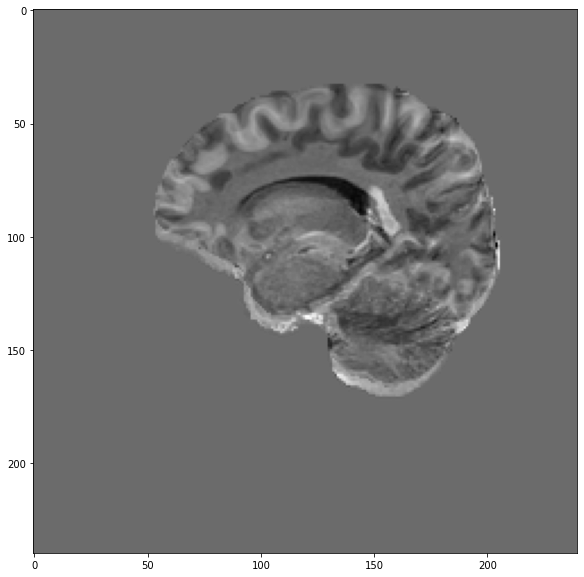

In [14]:
img_m = x_test[80, 1, ..., 0]
img_s = x_test[80, 0, ..., 0]
plt.imshow(img_m - img_s)

In [15]:
# img_rot = rotate(img, angle=12, reshape=False)
# plt.imshow(img_rot - img)

NameError: name 'img_rot' is not defined

In [16]:
model = tf.keras.models.load_model('/home/srivathsa/projects/studies/gad/vmorph/affine_2d/simple_cnn_e15/simple_cnn')

2021-09-20 20:03:04.708226: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-09-20 20:03:04.807366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-09-20 20:03:04.807945: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-09-20 20:03:04.811787: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-09-20 20:03:04.814999: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-09-20 20:03:04.817096: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

In [17]:
mov_unrot = x_test[80, 1, ..., 0]
# mov_rot = rotate(mov_unrot, angle=12, reshape=False)

s = x_test[80, 0][None]
m = mov_unrot[None, ..., None]

moved = model({'moving': m, 'static': s}, training=False)
mov = moved.numpy().squeeze()

2021-09-20 20:03:14.477459: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-09-20 20:03:15.639955: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


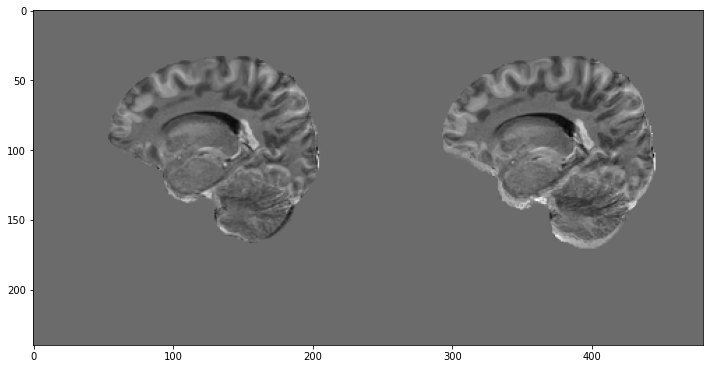

In [18]:
plt.imshow(np.hstack([mov-s[0, ..., 0], m[0, ..., 0] - s[0, ..., 0]]))

In [ ]:
plt.imshow(m[0, ..., 0] - s[0, ..., 0])

In [37]:
import pydicom
dcm = pydicom.dcmread('/mnt/datasets/ben/BRATS/train/00009/T1wCE/Image-100.dcm')
print(dcm.SliceThickness)
print(dcm.PixelSpacing)
img = np.array(dcm.pixel_array)
print(img.shape)

1.2
[0.5, 0.5]
(512, 512)


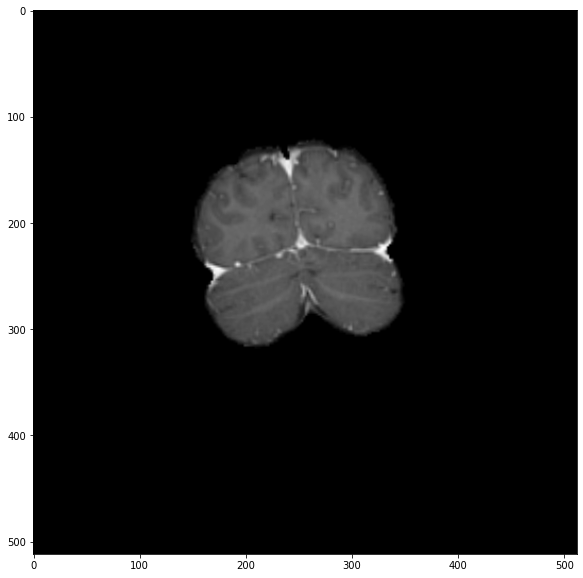

In [38]:
plt.imshow(img)

In [24]:
import nibabel as nib

data = nib.load('/home/srivathsa/projects/brats_2021/data/train/BraTS2021_00000/BraTS2021_00000_t1ce.nii.gz')
print(data.shape)

(240, 240, 155)
